In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('housing')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  842.4066772460938
final loss:  2.9948713779449463
initial loss:  849.228271484375
final loss:  3.0212883949279785
initial loss:  831.013916015625
final loss:  2.9635581970214844
initial loss:  821.1795043945312
final loss:  2.761523723602295
initial loss:  890.758056640625
final loss:  2.8988521099090576


Deep ensemble test MAPE:  0.12708263
Deep ensemble test RMSE:  3.878879
Deep ensemble test NLLK:  3.695167
Deep ensemble test CRPS:  tensor(2.0561)


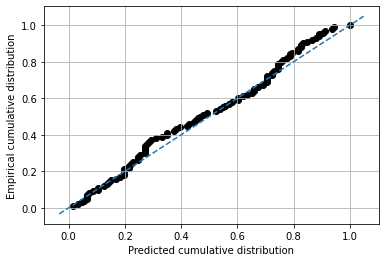

Deep ensemble test calibration error when step size is 0.001:  1.2704758125472422
Deep ensemble test calibration error when step size is 0.01:  0.12781683043587821
Deep ensemble test calibration error when step size is 0.1:  0.011123708742756373


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.59it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.66it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.745
  RMSE          3.879
  MDAE          1.937
  MARPD         12.618
  R2            0.837
  Correlation   0.916
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.054
  Mean-absolute Calibration Error       0.047
  Miscalibration Area                   0.047
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.165
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.047
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.190
     Group Size: 0.56 -- Calibration Error: 0.085
     Group Size: 1.00 -- Calibration Error: 0.054
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (6.870214, 49.080677)
lims: (6.870214, 50.0)
lims_ext: (2.5572352409362793, 54.312978744506836)


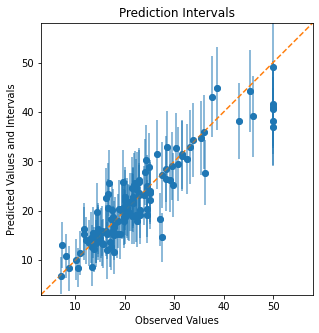

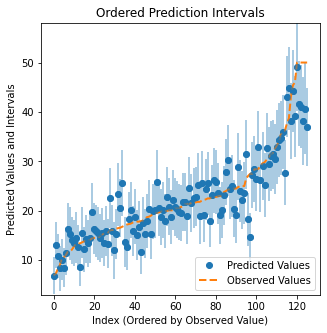

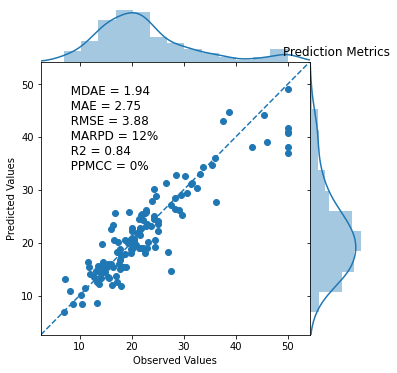

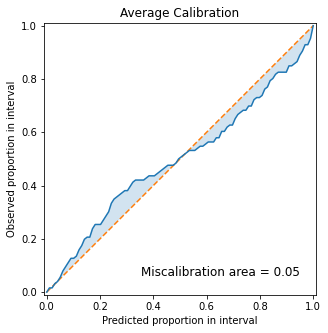

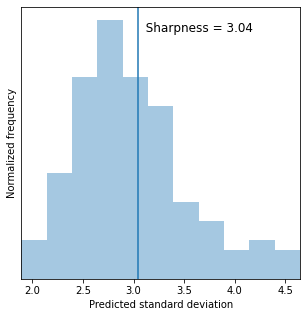

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [7]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 500, n_features = 100, learning_rate = 0.003)

final loss:  0.0267142653465271


Concrete dropout test MAPE:  0.11684448
Concrete dropout test RMSE:  4.258061
Concrete dropout test NLLK:  16.832197
Concrete dropout test CRPS:  tensor(2.1962)


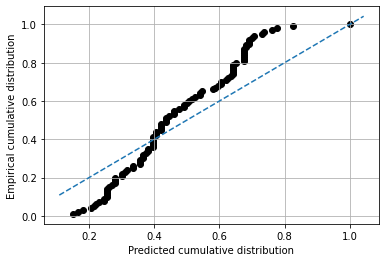

Concrete dropout test calibration error when step size is 0.001:  15.152693499622071
Concrete dropout test calibration error when step size is 0.01:  1.4945893172083649
Concrete dropout test calibration error when step size is 0.1:  0.12204585537918874


In [8]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [9]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


  0%|                                                   | 0/10 [00:00<?, ?it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.73it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.588
  RMSE          4.258
  MDAE          1.471
  MARPD         12.358
  R2            0.803
  Correlation   0.900
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.234
  Mean-absolute Calibration Error       0.200
  Miscalibration Area                   0.202
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.309
     Group Size: 0.56 -- Calibration Error: 0.233
     Group Size: 1.00 -- Calibration Error: 0.200
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.375
     Group Size: 0.56 -- Calibration Error: 0.279
     Group Size: 1.00 -- Calibration Error: 0.234
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (7.6319995, 53.632988)
lims: (7.0, 53.632988)
lims_ext: (2.336701202392578, 58.29628677368164)


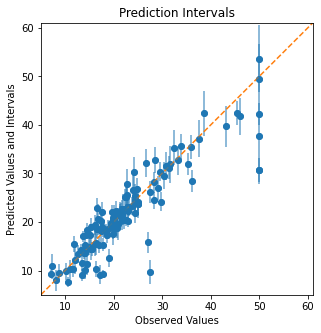

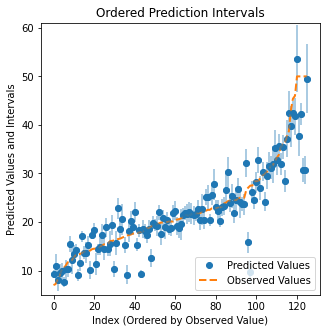

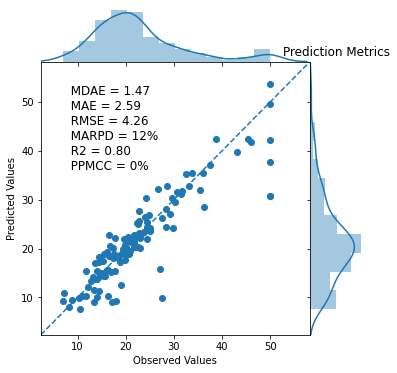

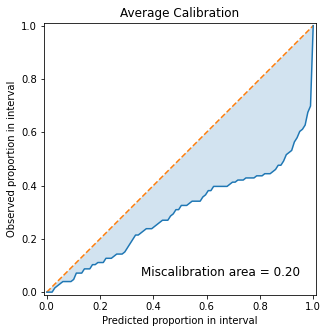

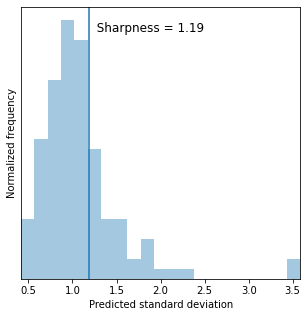

In [10]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [91]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  899.5330810546875
final loss:  3.364626407623291


Subnetwork test MAPE:  0.15481833
Subnetwork test RMSE:  4.0785904
Subnetwork test NLLK:  3.8448484
Subnetwork test CRPS:  tensor(2.2396)


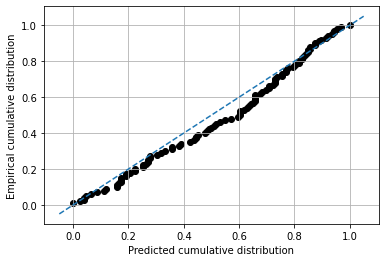

Subnetwork test calibration error when step size is 0.001:  2.3421900982615256
Subnetwork test calibration error when step size is 0.01:  0.2333799445704206
Subnetwork test calibration error when step size is 0.1:  0.026895943562610203


In [92]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [93]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.08it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.01it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           3.121
  RMSE          4.079
  MDAE          2.222
  MARPD         15.471
  R2            0.820
  Correlation   0.908
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.027
  Mean-absolute Calibration Error       0.021
  Miscalibration Area                   0.020
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.141
     Group Size: 0.56 -- Calibration Error: 0.056
     Group Size: 1.00 -- Calibration Error: 0.021
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.173
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.027
===============

Lims is None. Setting lims now:
min_max_true: (7.0, 50.0)
min_max_pred: (2.4436498, 50.252644)
lims: (2.4436498, 50.252644)
lims_ext: (-2.3372496604919437, 55.033543014526366)


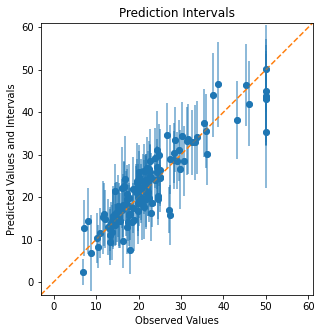

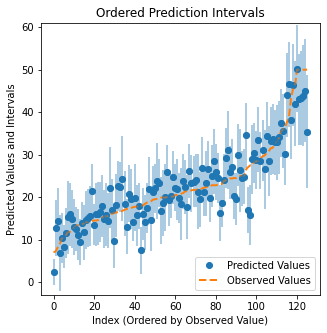

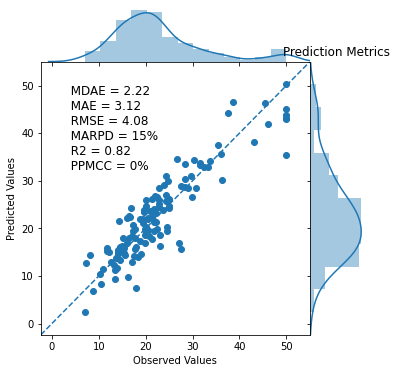

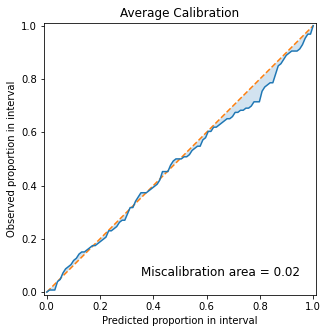

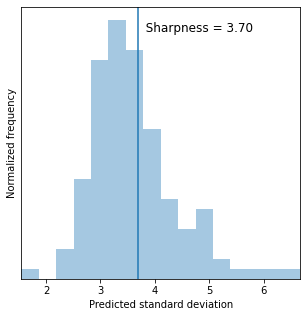

In [94]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))